In [1]:
# import MNIST from open ML

import numpy as np
import numpy.matlib 
from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.decomposition import PCA
import pandas as pd 


In [2]:
# if you are using Colab 

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# load training and test sets 

path_to_train = '/content/drive/My Drive/Colab Notebooks/MNIST_training_set.npy'
path_to_test = '/content/drive/My Drive/Colab Notebooks/MNIST_test_set.npy'

d_train = np.load(path_to_train, allow_pickle=True)
d_test = np.load(path_to_test, allow_pickle=True)

In [4]:
X_train = d_train.item().get('features')
Y_train = d_train.item().get('labels')

print(X_train.shape) # (2000, 256) - 16x16 pixels, each row is image, there are 2000 images
print(Y_train.shape) # (2000,)

X_test = d_test.item().get('features') 
Y_test = d_test.item().get('labels') 

print(X_test.shape) # (500, 256)
print(Y_test.shape) # (500,)

(2000, 256)
(2000,)
(500, 256)
(500,)


[1. 1. 1. 6. 0. 4. 9. 9. 3. 7. 1. 8. 3. 8. 7. 4. 3. 4. 0. 2. 5. 6. 2. 6.
 0. 0. 9. 0. 8. 1. 2. 7. 9. 7. 4. 5. 2. 4. 9. 3. 3. 1. 8. 8. 6. 4. 6. 3.
 0. 3. 1. 1. 7. 8. 9. 4. 0. 7. 7. 0. 0. 7. 2. 6.]


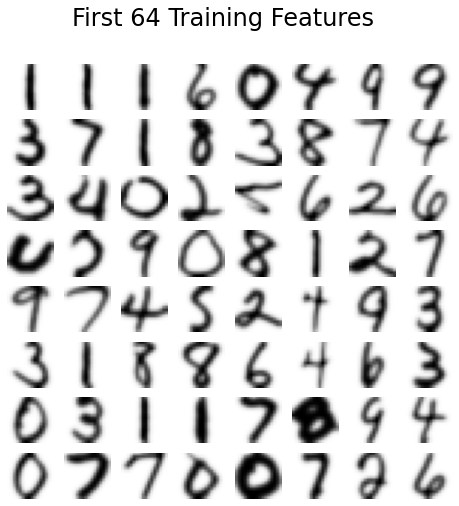

In [5]:
# Plot some of the training and test sets 
def plot_digits(XX, N, title):
    """Small helper function to plot N**2 digits."""
    fig, ax = plt.subplots(N, N, figsize=(8, 8))
    for i in range(N):
      for j in range(N):
        ax[i,j].imshow(XX[(N)*i+j,:].reshape((16, 16)), cmap="Greys")
        ax[i,j].axis("off")
    fig.suptitle(title, fontsize=24)

plot_digits(X_train, 8, "First 64 Training Features" )

print(Y_train[0:8**2])

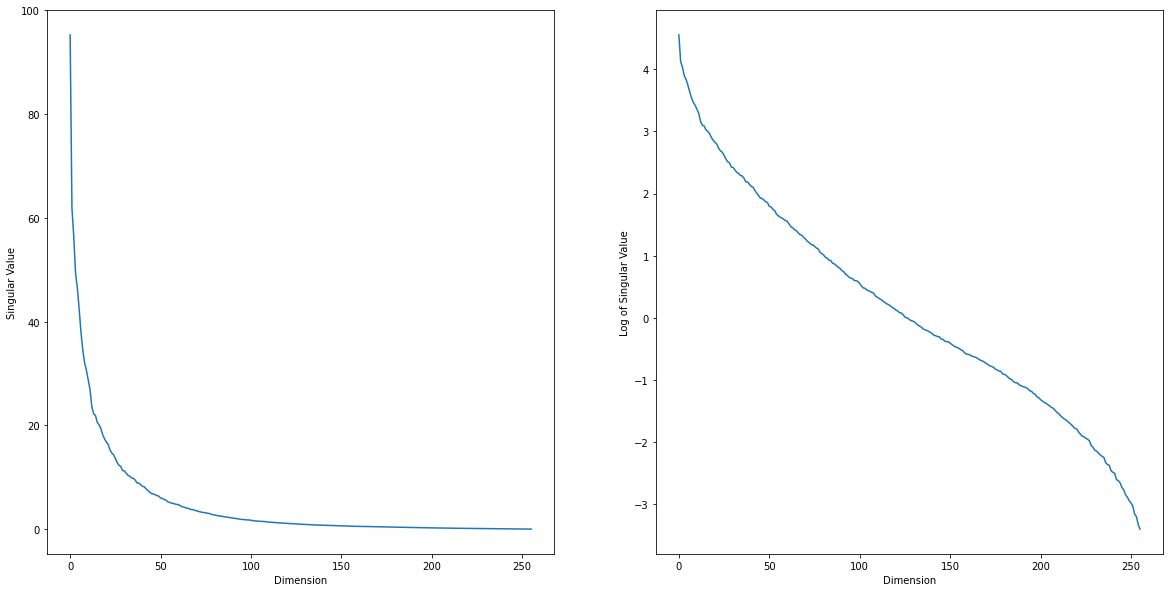

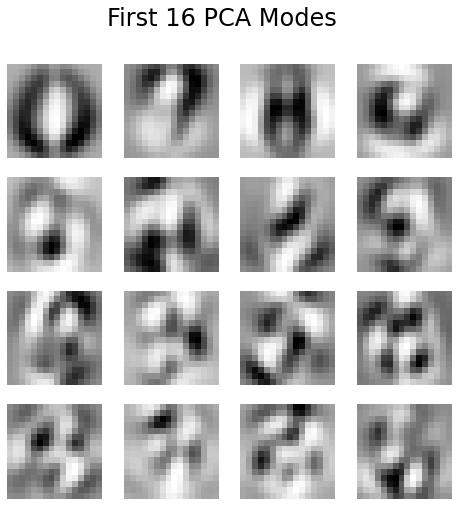

In [7]:
### Task 1: Use PCA to investigate dimensionality of X_train.
### Plot first 16 PCA modes as 16x16 images. 
pca = PCA(256)
pca.fit(X_train)
singular_vals = pca.singular_values_
singular_vals_norm = np.linalg.norm(pca.singular_values_)
singular_values_final = (singular_vals**2) / (singular_vals_norm**2)
singular_values_final_cumsum = (np.cumsum(singular_vals**2)) / (singular_vals_norm**2)

fig1, ax1 = plt.subplots(1,2,figsize=(20,10))
ax1[0].plot(singular_vals) # Singular Values 
ax1[0].set_xlabel('Dimension')
ax1[0].set_ylabel('Singular Value')
ax1[1].plot(np.log(singular_vals)) # Log singular values 
ax1[1].set_xlabel('Dimension')
ax1[1].set_ylabel('Log of Singular Value')

# fig2, ax2 = plt.subplots(figsize=(10,10))
# ax2.plot(singular_values_final, '-b', label='Singular Values (Normalized)') # Normalized Singular Values 
# ax2.plot(singular_values_final_cumsum, '-r', label='Cumulative Sum of Singular Values (Normalized)')
# ax2.legend()

pca_train = PCA(16)
pca_train.fit(X_train)
plot_digits(pca_train.components_, 4, "First 16 PCA Modes")

3 7 14
           0
0   0.500538
1   0.596946
2   0.666556
3   0.715075
4   0.755646
5   0.787792
6   0.812658
7   0.832640
8   0.849503
9   0.864623
10  0.877719
11  0.889042
12  0.897639
13  0.905229
14  0.912540


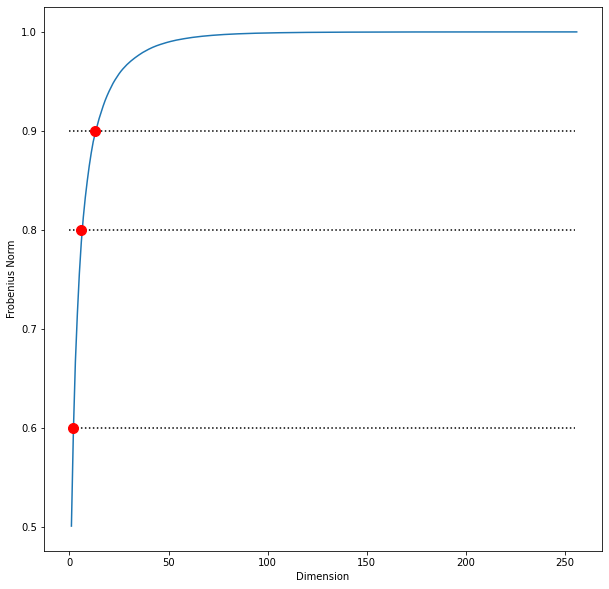

In [18]:
### Task 2: How many PCA modes do you need to keep to approximate 
### X_train up to 60%, 80%, 90% in Frobenius norm?
### Do you need the entire 16x16 image for each datapoint?

pca60 = PCA(0.6**2)
pca60.fit(X_train)
components60 = pca60.components_
required_PCA_Modes60 = components60.shape[0]

pca80 = PCA(0.8**2)
pca80.fit(X_train)
components80 = pca80.components_
required_PCA_Modes80 = components80.shape[0]

pca90 = PCA(0.9**2)
pca90.fit(X_train)
components90 = pca90.components_
required_PCA_Modes90 = components90.shape[0]
print(required_PCA_Modes60, required_PCA_Modes80, required_PCA_Modes90)

fig3, ax3 = plt.subplots(figsize=(10,10))
singular_values_final_cumsum_sqrt = np.sqrt(singular_values_final_cumsum)
ax3.plot(range(1,(256+1)), singular_values_final_cumsum_sqrt)
ax3.plot([0.6]*256, 'k:')
ax3.plot([0.8]*256, 'k:')
ax3.plot([0.9]*256, 'k:')
ax3.plot(required_PCA_Modes60-1, 0.6, "or", markersize=10)
ax3.plot(required_PCA_Modes80-1, 0.8, "or", markersize=10)
ax3.plot(required_PCA_Modes90-1, 0.9, "or", markersize=10)
ax3.set_xlabel('Dimension')
ax3.set_ylabel('Frobenius Norm')
print(pd.DataFrame(singular_values_final_cumsum_sqrt[0:15]))

In [20]:
### Task 3: Train a classifier to distinguish the digits 1 and 8. 
def chooseLabels(X, Y, digit1, digit2):
  indices = [index for index, label in enumerate(Y) if (label==digit1 or label==digit2)]
  labels = [label for index, label in enumerate(Y) if (label==digit1 or label==digit2)]
  b = [-1 if label==digit1 else 1 for label in labels]
  return X[indices,:], labels, b

def calculateMSE(X_train, Y_train, X_test, Y_test, digit1, digit2):
  # training 
  Xtrain_part, Ytrain_part, b_train = chooseLabels(X_train, Y_train, digit1, digit2)
  A_train = pca_train.transform(Xtrain_part) 

  reg = linear_model.Ridge(alpha=1) # alpha wont change things too much 
  reg.fit(A_train, b_train)
  betas_train = np.insert(reg.coef_, 0, reg.intercept_) # insert the intercept to front of (index 0) coef list
  A_train = np.insert(A_train, 0, np.ones(A_train.shape[0]), axis=1)
  MSE_train = 1/(len(b_train)) * (np.linalg.norm(A_train @ betas_train - b_train)**2)

  # testing 
  Xtest_part, Y_test_part, b_test = chooseLabels(X_test, Y_test, digit1, digit2)
  A_test = pca_train.transform(Xtest_part)
  b_test_predict = reg.predict(A_test)
  MSE_test = 1/(len(b_test)) * (np.linalg.norm(b_test_predict - b_test)**2)

  return MSE_train, MSE_test

MSE_train_18, MSE_test_18 = calculateMSE(X_train, Y_train, X_test, Y_test, 1, 8)
MSE_train_38, MSE_test_38 = calculateMSE(X_train, Y_train, X_test, Y_test, 3, 8)
MSE_train_27, MSE_test_27 = calculateMSE(X_train, Y_train, X_test, Y_test, 2, 7)
print(MSE_train_18, MSE_test_18, MSE_train_38, MSE_test_38, MSE_train_27, MSE_test_27)


0.07461023471137328 0.08328783573295792 0.18041519881287735 0.2581897268224532 0.09179345340305953 0.13649226388956198


In [ ]:
### Task 4: Train classifiers for the pairs of digits (3,8) and 
### (2,7) and report the training and test MSEs. 
### Can you explain the performance variations?
MSE_train_38, MSE_test_38 = calculateMSE(X_train, Y_train, X_test, Y_test, 3, 8)
MSE_train_27, MSE_test_27 = calculateMSE(X_train, Y_train, X_test, Y_test, 2, 7)
print(MSE_train_18, MSE_test_18, MSE_train_38, MSE_test_38, MSE_train_27, MSE_test_27)


0.03183336400714473 0.07109517936840375 0.10116426531347802 0.20638210258748257 0.05140383914966936 0.11380349677667516


          0         1         2  ...         7         8         9
0       0.0  0.036788  0.166079  ...   0.07464  0.111434   0.07177
1  0.036788       0.0    0.0563  ...  0.047192  0.074611  0.058306
2  0.166079    0.0563       0.0  ...  0.091793   0.18219  0.105953
3  0.126987  0.041542  0.123075  ...  0.094873  0.180406  0.097634
4  0.088804  0.089307  0.196771  ...  0.126136  0.134533  0.180749
5  0.167515  0.055989   0.18246  ...   0.12339   0.19227  0.121892
6  0.127489  0.047233  0.151233  ...  0.066234  0.123315  0.076533
7   0.07464  0.047192  0.091793  ...       0.0  0.100897  0.246446
8  0.111434  0.074611   0.18219  ...  0.100897       0.0  0.125979
9   0.07177  0.058306  0.105953  ...  0.246446  0.125979       0.0

[10 rows x 10 columns]
          0         1         2  ...         7         8         9
0       0.0  0.064596  0.139677  ...  0.084597  0.148546  0.066528
1  0.064596       0.0  0.103609  ...  0.081579  0.083288  0.066502
2  0.139677  0.103609       0.0  ...  

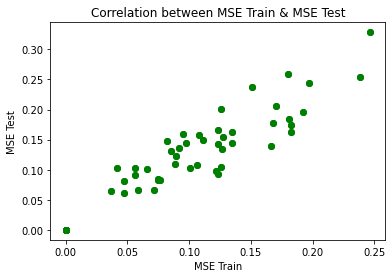

In [ ]:
# TRY: get MSE for all combos and find pattern 
MSES_trains = pd.DataFrame(None, index=np.arange(10), columns=np.arange(10))
MSES_tests = pd.DataFrame(None, index=np.arange(10), columns=np.arange(10))
for row in range(10):
  for col in range(10):
    MSE_train, MSE_test = calculateMSE(X_train, Y_train, X_test, Y_test, row, col)
    MSES_trains[col][row] = MSE_train
    MSES_tests[col][row] = MSE_test

print(MSES_trains)
print(MSES_tests)


plt.plot(MSES_trains[0], MSES_tests[0], "go")
plt.plot(MSES_trains[1], MSES_tests[1], "go")
plt.plot(MSES_trains[2], MSES_tests[2], "go")
plt.plot(MSES_trains[3], MSES_tests[3], "go")
plt.plot(MSES_trains[4], MSES_tests[4], "go")
plt.plot(MSES_trains[5], MSES_tests[5], "go")
plt.plot(MSES_trains[6], MSES_tests[6], "go")
plt.plot(MSES_trains[7], MSES_tests[7], "go")
plt.plot(MSES_trains[8], MSES_tests[8], "go")
plt.plot(MSES_trains[9], MSES_tests[9], "go")
plt.xlabel("MSE Train")
plt.ylabel("MSE Test")
plt.title("Correlation between MSE Train & MSE Test")
plt.show()